# Chapter 7: Ensemble Learning and Random Forests - Notebook Reproduksi Kode

Bab ini mengeksplorasi Ensemble Learning dan Random Forests.
Ensemble Learning menggabungkan prediksi dari beberapa prediktor
untuk mencapai kinerja yang lebih baik daripada prediktor tunggal.

Kita akan melihat:
- Voting Classifiers (Hard dan Soft Voting)
- Bagging dan Pasting
- Out-of-Bag Evaluation
- Random Forests dan Extra-Trees
- Feature Importance
- Boosting (AdaBoost dan Gradient Boosting)
- Stacking

--- Voting Classifiers (Hard Voting) ---
Melatih Hard Voting Classifier...
Hard Voting Classifier berhasil dilatih.

Kinerja Classifier Individual dan Hard Voting:
LogisticRegression: 0.8520
RandomForestClassifier: 0.9120
SVC: 0.9160
VotingClassifier: 0.9080

--- Voting Classifiers (Soft Voting) ---
Melatih Soft Voting Classifier...
Soft Voting Classifier berhasil dilatih.

Kinerja Classifier Individual dan Soft Voting:
LogisticRegression: 0.8520
RandomForestClassifier: 0.9120
SVC: 0.9160
VotingClassifier: 0.9160

--- Bagging dan Pasting ---
Melatih BaggingClassifier...
Akurasi BaggingClassifier: 0.9160
Akurasi Base Decision Tree: 0.8920


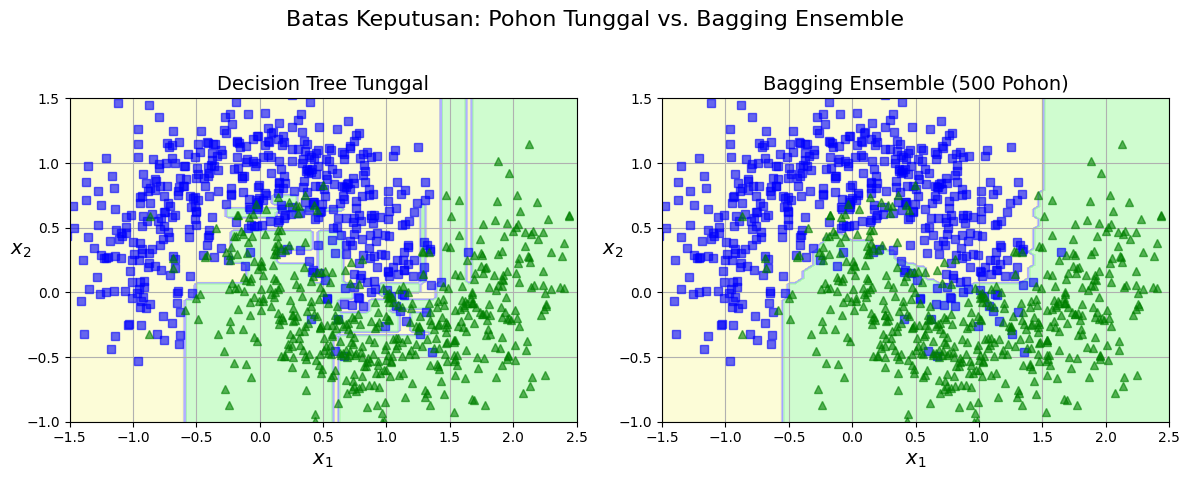


--- Out-of-Bag (OOB) Evaluation ---
Melatih BaggingClassifier dengan OOB Score...
BaggingClassifier dengan OOB Score berhasil dilatih.
OOB Score: 0.8960
Akurasi pada set pengujian: 0.9120

--- Random Forests ---
Melatih RandomForestClassifier...
Akurasi RandomForestClassifier: 0.9200

--- Extra-Trees ---
Melatih ExtraTreesClassifier...
Akurasi ExtraTreesClassifier: 0.9000

--- Feature Importance (Dataset MNIST) ---
Melatih RandomForestClassifier pada subset MNIST...
RandomForestClassifier MNIST berhasil dilatih.
Bentuk Feature Importances: (784,)


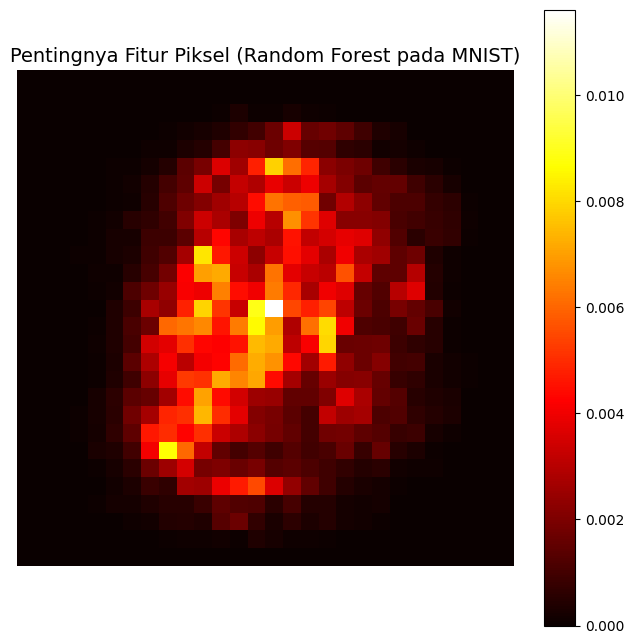


--- Boosting (AdaBoost) ---
Melatih AdaBoostClassifier...


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Akurasi AdaBoostClassifier: 0.9280

--- Boosting (Gradient Boosting Regressor) ---
Melatih GradientBoostingRegressor...
GradientBoostingRegressor berhasil dilatih.
Jumlah estimator optimal dengan early stopping: 32
RMSE GradientBoostingRegressor (optimal estimators): 0.4982


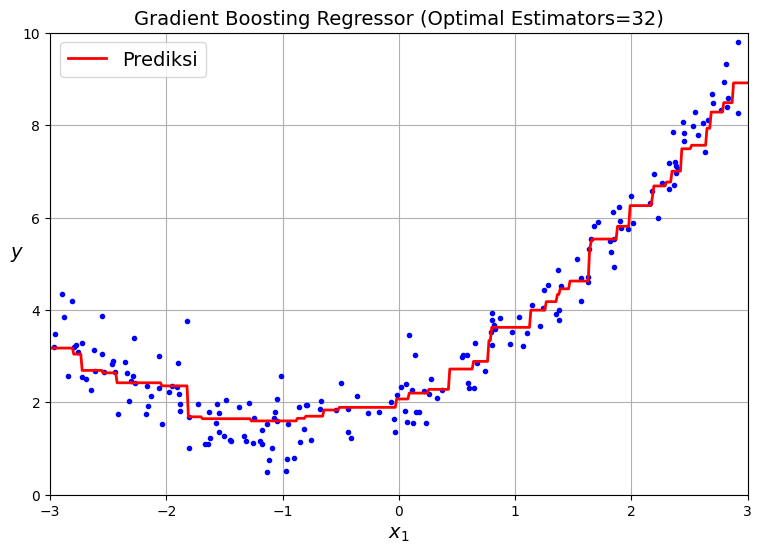


--- Stacking (Konsep Dasar Manual) ---
Melatih prediktor layer pertama...
Prediktor layer pertama berhasil dilatih.
Bentuk fitur untuk blender (dari holdout): (225, 2)
Melatih blender...
Blender berhasil dilatih.
Akurasi Stacking Ensemble (manual): 0.9320
Perbandingan dengan classifier individual terbaik:
Akurasi RandomForestClassifier (individual): 0.9240
Akurasi SVC (individual): 0.9200
Akurasi LogisticRegression (individual): 0.8520

--- Selesai Reproduksi Kode Chapter 7 ---


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl # FIX: Menambahkan impor eksplisit untuk mpl
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.datasets import make_moons, fetch_openml
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor # Untuk base estimator
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score
from sklearn.base import clone # Untuk latihan/debugging

# --- 1. Voting Classifiers ---

# Menggunakan dataset moons untuk klasifikasi
X_moons, y_moons = make_moons(n_samples=1000, noise=0.30, random_state=42)
X_train_moons, X_test_moons, y_train_moons, y_test_moons = train_test_split(X_moons, y_moons, random_state=42)

# Siapkan beberapa classifier yang beragam
log_clf = LogisticRegression(solver="lbfgs", random_state=42, max_iter=1000)
rnd_clf = RandomForestClassifier(random_state=42)
# SVC membutuhkan probability=True untuk soft voting
svm_clf = SVC(probability=True, random_state=42, gamma="scale")

# Hard Voting Classifier
print("--- Voting Classifiers (Hard Voting) ---")
voting_clf_hard = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard' # Default, tapi dieksplisitkan
)
print("Melatih Hard Voting Classifier...")
voting_clf_hard.fit(X_train_moons, y_train_moons)
print("Hard Voting Classifier berhasil dilatih.")

print("\nKinerja Classifier Individual dan Hard Voting:")
for clf in (log_clf, rnd_clf, svm_clf, voting_clf_hard):
    clf.fit(X_train_moons, y_train_moons)
    y_pred = clf.predict(X_test_moons)
    print(f"{clf.__class__.__name__}: {accuracy_score(y_test_moons, y_pred):.4f}")

# Soft Voting Classifier (jika semua classifier mendukung predict_proba)
print("\n--- Voting Classifiers (Soft Voting) ---")
voting_clf_soft = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft'
)
print("Melatih Soft Voting Classifier...")
voting_clf_soft.fit(X_train_moons, y_train_moons)
print("Soft Voting Classifier berhasil dilatih.")

print("\nKinerja Classifier Individual dan Soft Voting:")
for clf in (log_clf, rnd_clf, svm_clf, voting_clf_soft):
    # Tidak perlu fit ulang, sudah di-fit di atas atau voting_clf akan fit ulang secara internal
    y_pred = clf.predict(X_test_moons)
    print(f"{clf.__class__.__name__}: {accuracy_score(y_test_moons, y_pred):.4f}")

# --- 2. Bagging dan Pasting ---
# Menggunakan BaggingClassifier untuk mendemonstrasikan bagging dan pasting.

print("\n--- Bagging dan Pasting ---")
# Bagging Classifier (default: bootstrap=True)
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42, n_jobs=-1, verbose=0 # n_jobs=-1 gunakan semua core
)
print("Melatih BaggingClassifier...")
bag_clf.fit(X_train_moons, y_train_moons)
y_pred_bag = bag_clf.predict(X_test_moons)
print(f"Akurasi BaggingClassifier: {accuracy_score(y_test_moons, y_pred_bag):.4f}")


# Base Decision Tree (untuk perbandingan)
tree_clf_base = DecisionTreeClassifier(random_state=42)
tree_clf_base.fit(X_train_moons, y_train_moons)
y_pred_tree_base = tree_clf_base.predict(X_test_moons)
print(f"Akurasi Base Decision Tree: {accuracy_score(y_test_moons, y_pred_tree_base):.4f}")


# Visualisasi batas keputusan
def plot_ensemble_decision_boundary(clf, X, y, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X_plot = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X_plot).reshape(x0.shape)
    custom_cmap = mpl.colors.ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
    plt.contourf(x0, x1, y_pred, cmap=custom_cmap, alpha=0.5)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", alpha=0.6)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", alpha=0.6)
    plt.xlabel(r"$x_1$", fontsize=14)
    plt.ylabel(r"$x_2$", fontsize=14, rotation=0)
    plt.axis(axes)
    plt.grid(True)

plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_ensemble_decision_boundary(tree_clf_base, X_moons, y_moons, [-1.5, 2.5, -1, 1.5])
plt.title("Decision Tree Tunggal", fontsize=14)

plt.subplot(122)
plot_ensemble_decision_boundary(bag_clf, X_moons, y_moons, [-1.5, 2.5, -1, 1.5])
plt.title("Bagging Ensemble (500 Pohon)", fontsize=14)
plt.suptitle("Batas Keputusan: Pohon Tunggal vs. Bagging Ensemble", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# --- 3. Out-of-Bag (OOB) Evaluation ---
# Dengan bagging, beberapa instance tidak pernah disampel untuk prediktor tertentu.
# Mereka bisa digunakan untuk evaluasi.

print("\n--- Out-of-Bag (OOB) Evaluation ---")
bag_clf_oob = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, random_state=42, n_jobs=-1, oob_score=True
)
print("Melatih BaggingClassifier dengan OOB Score...")
bag_clf_oob.fit(X_train_moons, y_train_moons)
print("BaggingClassifier dengan OOB Score berhasil dilatih.")

print(f"OOB Score: {bag_clf_oob.oob_score_:.4f}")
y_pred_oob = bag_clf_oob.predict(X_test_moons)
print(f"Akurasi pada set pengujian: {accuracy_score(y_test_moons, y_pred_oob):.4f}")


# --- 4. Random Forests dan Extra-Trees ---
# RandomForestClassifier adalah BaggingClassifier yang dioptimalkan untuk Decision Trees.

print("\n--- Random Forests ---")
rnd_forest_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42, n_jobs=-1)
print("Melatih RandomForestClassifier...")
rnd_forest_clf.fit(X_train_moons, y_train_moons)
y_pred_rf = rnd_forest_clf.predict(X_test_moons)
print(f"Akurasi RandomForestClassifier: {accuracy_score(y_test_moons, y_pred_rf):.4f}")

# Extra-Trees Classifier (Random Forests dengan randomness ekstra pada thresholding)
print("\n--- Extra-Trees ---")
extra_trees_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42, n_jobs=-1)
print("Melatih ExtraTreesClassifier...")
extra_trees_clf.fit(X_train_moons, y_train_moons)
y_pred_et = extra_trees_clf.predict(X_test_moons)
print(f"Akurasi ExtraTreesClassifier: {accuracy_score(y_test_moons, y_pred_et):.4f}")


# --- 5. Feature Importance ---
# Random Forests dapat mengukur pentingnya setiap fitur.
# Menggunakan dataset MNIST untuk demonstrasi.

print("\n--- Feature Importance (Dataset MNIST) ---")
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
X_mnist, y_mnist = mnist["data"], mnist["target"]
X_train_mnist, X_test_mnist, y_train_mnist, y_test_mnist = train_test_split(X_mnist, y_mnist, random_state=42)

# Latih Random Forest pada sebagian kecil data MNIST untuk kecepatan
# Karena fitur importance bisa memakan waktu untuk dihitung pada dataset besar
rf_mnist = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
print("Melatih RandomForestClassifier pada subset MNIST...")
rf_mnist.fit(X_train_mnist[:10000], y_train_mnist[:10000]) # Latih pada 10k sampel
print("RandomForestClassifier MNIST berhasil dilatih.")

importances = rf_mnist.feature_importances_
print(f"Bentuk Feature Importances: {importances.shape}")

# Visualisasikan pentingnya piksel (seperti Gambar 7-6 di buku)
plt.figure(figsize=(8, 8))
plt.imshow(importances.reshape(28, 28), cmap="hot")
plt.title("Pentingnya Fitur Piksel (Random Forest pada MNIST)", fontsize=14)
plt.colorbar()
plt.axis("off")
plt.show()

# --- 6. Boosting ---

# a. AdaBoost
print("\n--- Boosting (AdaBoost) ---")
# Base estimator default: DecisionTreeClassifier(max_depth=1) -> Decision Stump
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1, random_state=42), n_estimators=200,
    algorithm="SAMME", learning_rate=0.5, random_state=42 # FIX: Mengubah algorithm="SAMME.R" menjadi "SAMME"
)
print("Melatih AdaBoostClassifier...")
ada_clf.fit(X_train_moons, y_train_moons)
y_pred_ada = ada_clf.predict(X_test_moons)
print(f"Akurasi AdaBoostClassifier: {accuracy_score(y_test_moons, y_pred_ada):.4f}")


# b. Gradient Boosting
# Menggunakan data regresi non-linier dari Chapter 4
np.random.seed(42)
X_gb = 6 * np.random.rand(200, 1) - 3
y_gb = 0.5 * X_gb**2 + X_gb + 2 + np.random.randn(200, 1) * 0.5

# Bagi data untuk early stopping
X_train_gb, X_val_gb, y_train_gb, y_val_gb = train_test_split(X_gb, y_gb, test_size=0.2, random_state=42)

print("\n--- Boosting (Gradient Boosting Regressor) ---")
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, learning_rate=0.1, random_state=42)
print("Melatih GradientBoostingRegressor...")
gbrt.fit(X_train_gb, y_train_gb.ravel())
print("GradientBoostingRegressor berhasil dilatih.")

# Early stopping (mencari jumlah estimator optimal)
errors = [mean_squared_error(y_val_gb, y_pred) for y_pred in gbrt.staged_predict(X_val_gb)]
bst_n_estimators = np.argmin(errors) + 1
print(f"Jumlah estimator optimal dengan early stopping: {bst_n_estimators}")

# Model terbaik dengan jumlah estimator optimal
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, learning_rate=0.1, random_state=42)
gbrt_best.fit(X_train_gb, y_train_gb.ravel())
# FIX: Menggunakan y_val_gb untuk evaluasi RMSE pada model Gradient Boosting
rmse_gbrt_best = np.sqrt(mean_squared_error(y_val_gb, gbrt_best.predict(X_val_gb)))
print(f"RMSE GradientBoostingRegressor (optimal estimators): {rmse_gbrt_best:.4f}")

# Visualisasi regresi
def plot_gb_predictions(reg, X, y, axes=[-3, 3, 0, 10]):
    x1s = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = reg.predict(x1s)
    plt.plot(X, y, "b.")
    plt.plot(x1s, y_pred, "r-", linewidth=2, label="Prediksi")
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$y$", fontsize=14, rotation=0)
    plt.axis(axes)
    plt.grid(True)
    plt.legend(loc="upper left", fontsize=14)

plt.figure(figsize=(9, 6))
plot_gb_predictions(gbrt_best, X_gb, y_gb)
plt.title(f"Gradient Boosting Regressor (Optimal Estimators={bst_n_estimators})", fontsize=14)
plt.show()


# --- 7. Stacking ---
# Stacking tidak memiliki implementasi langsung di Scikit-Learn
# (tapi ada di versi lebih baru sklearn.ensemble.StackingClassifier/Regressor)
# Namun, konsepnya bisa didemonstrasikan secara manual.
# Kita akan mendemonstrasikan ide dasar stacking.

print("\n--- Stacking (Konsep Dasar Manual) ---")
# Step 1: Latih prediktor layer pertama pada subset data.
X_train_stack, X_holdout_stack, y_train_stack, y_holdout_stack = train_test_split(
    X_train_moons, y_train_moons, test_size=0.3, random_state=42
)

# Prediktor layer pertama
clf1 = RandomForestClassifier(random_state=42)
clf2 = SVC(probability=True, random_state=42, gamma='scale')

print("Melatih prediktor layer pertama...")
clf1.fit(X_train_stack, y_train_stack)
clf2.fit(X_train_stack, y_train_stack)
print("Prediktor layer pertama berhasil dilatih.")

# Step 2: Hasilkan prediksi pada set holdout. Ini akan menjadi fitur untuk blender.
X_holdout_preds = np.c_[clf1.predict_proba(X_holdout_stack)[:, 1], # Probabilitas kelas positif
                        clf2.predict_proba(X_holdout_stack)[:, 1]]

print(f"Bentuk fitur untuk blender (dari holdout): {X_holdout_preds.shape}")

# Step 3: Latih blender (meta-learner) pada prediksi holdout.
blender = LogisticRegression(solver="lbfgs", random_state=42)
print("Melatih blender...")
blender.fit(X_holdout_preds, y_holdout_stack)
print("Blender berhasil dilatih.")

# Evaluasi stacking ensemble pada set pengujian
# Prediksi dari prediktor layer pertama pada set pengujian
X_test_preds = np.c_[clf1.predict_proba(X_test_moons)[:, 1],
                     clf2.predict_proba(X_test_moons)[:, 1]]

# Prediksi akhir dari blender
y_pred_stack = blender.predict(X_test_preds)

print(f"Akurasi Stacking Ensemble (manual): {accuracy_score(y_test_moons, y_pred_stack):.4f}")
print("Perbandingan dengan classifier individual terbaik:")
print(f"Akurasi RandomForestClassifier (individual): {accuracy_score(y_test_moons, clf1.predict(X_test_moons)):.4f}")
print(f"Akurasi SVC (individual): {accuracy_score(y_test_moons, clf2.predict(X_test_moons)):.4f}")
print(f"Akurasi LogisticRegression (individual): {accuracy_score(y_test_moons, log_clf.predict(X_test_moons)):.4f}")


print("\n--- Selesai Reproduksi Kode Chapter 7 ---")